In [1]:
import os
os.chdir('../')

In [2]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from typing import List, Union, Tuple, Dict

import cv2
from IPython.display import clear_output
from time import sleep

import math
import random
from collections import defaultdict
from einops.layers.torch import Rearrange

import torch
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

from src.opts.opts import parser
from src.utils.reproducibility import make_reproducible
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset, prepare_clips_data
from src.dataset.video_transforms import (
    IdentityTransform,
    GroupScale, 
    GroupCenterCrop, 
    GroupRandomCrop,
    GroupMultiScaleCrop,
    Stack, 
    ToTorchFormatTensor, 
    GroupNormalize, 
    GroupRandomHorizontalFlip,
    GroupRotate
)

%load_ext autoreload
%autoreload 2

In [3]:
args = parser.parse_args(args=[])
args.base_model = 'InceptionV3'
args.fusion_mode = "GSF"
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist/HoloAssist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1_2',
 'fga_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'base_model': 'InceptionV3',
 'fusion_mode': 'GSF',
 'num_segments': 8,
 'num_classes': 1887,
 'resume': None,
 'start_epoch': 0,
 'pretrained': 'ImageNet',
 'num_epochs': 10,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'batch_size': 16,
 'num_workers': 4,
 'prefetch_factor': 2,
 'debug': False,
 'fps': 10}

In [4]:
# Fix random state to make results reproducible
make_reproducible(random_seed=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=args.num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    verbose=False,
    pretrained="ImageNet"
).to(device)

input_size = model.input_size
crop_size = model.crop_size
input_mean = model.input_mean
input_std = model.input_std
learnable_named_parameters = model.learnable_named_parameters

Making reproducible on seed 0
=> Using ImageNet weights
=> Using GSF fusion
No. of GSF modules = 11


In [5]:
tr_video_name_arr, tr_start_arr, tr_end_arr, tr_label_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fga_map_file=args.fga_map_file,
    mode="train",
)

transform = Compose([
    GroupMultiScaleCrop(input_size=crop_size, scales=[1, .875]),
    Stack(),
    ToTorchFormatTensor(div=(args.base_model not in ['BNInception'])),
    GroupNormalize(mean=input_mean, std=input_std),
])

tr_dataset = VideoDataset(
    holoassist_dir=args.holoassist_dir,
    video_name_arr=tr_video_name_arr,
    start_arr=tr_start_arr,
    end_arr=tr_end_arr,
    label_arr=tr_label_arr,
    num_segments=args.num_segments,
    transform=None,
    mode="train"
)


There are 1466 videos in the split list file. 
There are 21 videos downloaded and stored on the disk 
There are 1454 videos that present in the list but are missing on the disk.


In [6]:
tr_video_name_arr[328], tr_start_arr[328], tr_end_arr[328]

(b'z182-sep-08-22-printer_big', 34.1, 36.3)

In [7]:
def animate(frames):

    plt.figure()
    for i in range(len(frames)):
        plt.imshow(frames[i])
        plt.axis('off')  
        plt.show()
        sleep(0.1)
        clear_output(wait=True)

In [35]:
frames, action = tr_dataset[345]
print(action)

272


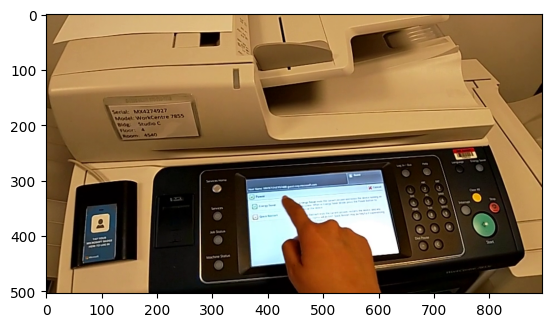

In [36]:
plt.imshow(frames[5])

1389


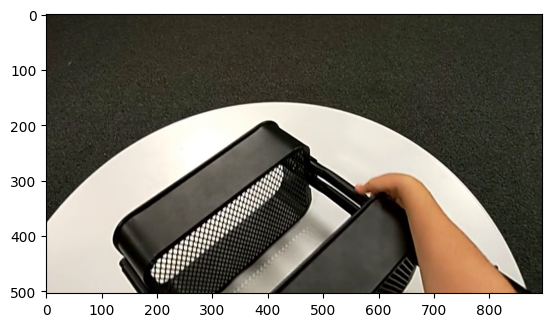

In [61]:
frames, action = tr_dataset[415]
print(action)
plt.imshow(frames[5])

In [17]:
print(np.array(frames[0]).shape) # numpy
print(frames[0].size) # PIL Image

(504, 896, 3)
(896, 504)


# Original

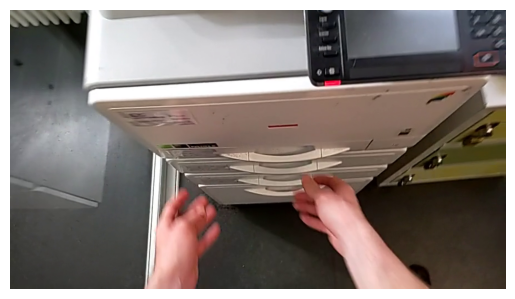

In [12]:
animate(frames)

# GroupScale

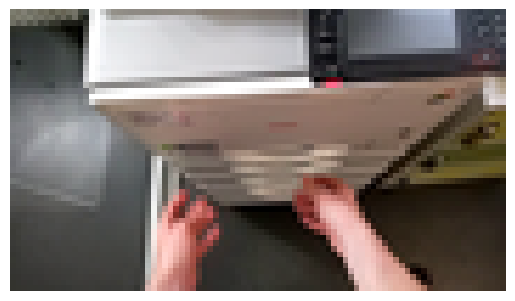

In [10]:
transform = GroupScale(size=50)
animate(transform((frames)))

# GroupRandomHorizontalFlip

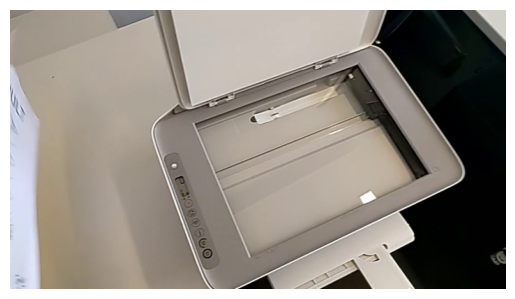

In [57]:
transform = Compose([
    GroupScale(size=400),
    GroupRandomHorizontalFlip(),
])
animate(transform((frames)))

# GroupCenterCrop

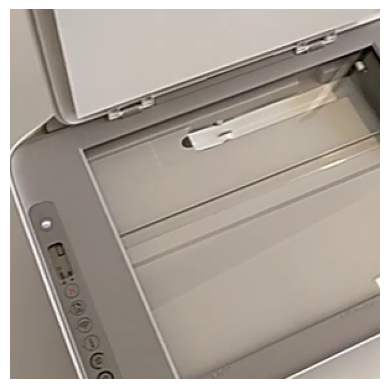

In [58]:
transform = Compose([
    GroupScale(size=400),
    GroupCenterCrop(size=crop_size),
])
animate(transform((frames)))

# GroupRandomCrop

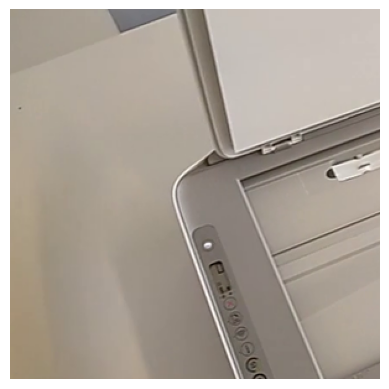

In [59]:
transform = Compose([
    GroupScale(size=350),
    GroupRandomCrop(size=crop_size)
])
animate(transform((frames)))

# GroupRotate

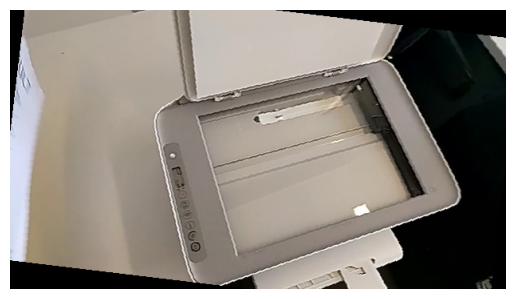

In [60]:
transform = Compose([
    GroupScale(size=350),
    GroupRotate(angle_range=(-30.0, 30.0), probability=1)
])
animate(transform((frames)))

# GroupMultiScaleCrop

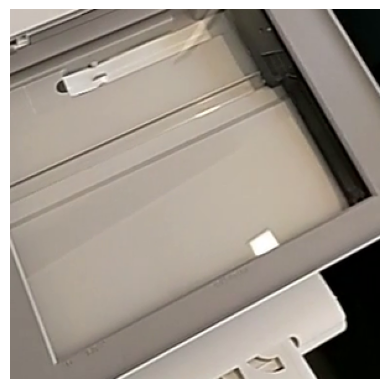

In [80]:
transform = Compose([
    # GroupScale(size=350),
    GroupMultiScaleCrop(input_size=crop_size, scales=[1., 0.875, 0.75, 0.66])
])
animate(transform((frames)))

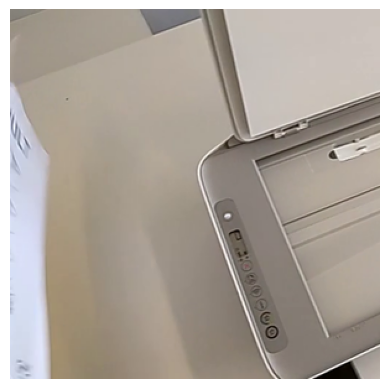

In [102]:
transform = Compose([
    # GroupScale(size=350),
    GroupMultiScaleCrop(input_size=crop_size, scales=[1., 0.875])
])
animate(transform((frames)))

# Scale + crop

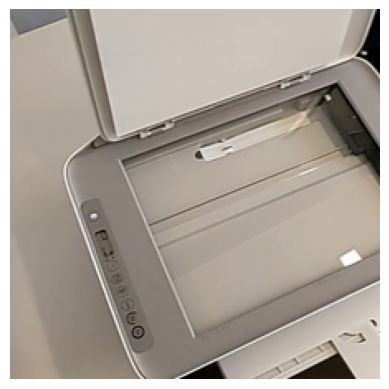

In [69]:
transform = Compose([
    GroupScale(size=224),
    GroupRandomCrop(size=224),
])
animate(transform((frames)))

In [13]:
transform = Compose([
    GroupScale(size=224),
    GroupRandomCrop(size=224),
    Stack(),
    ToTorchFormatTensor(),
])
transform((frames))

tensor([[[0.3529, 0.3529, 0.3529,  ..., 0.6627, 0.6627, 0.6510],
         [0.3647, 0.3686, 0.3686,  ..., 0.6784, 0.6824, 0.6706],
         [0.3804, 0.3843, 0.3882,  ..., 0.6745, 0.6784, 0.6706],
         ...,
         [0.1843, 0.1804, 0.1804,  ..., 0.4941, 0.5098, 0.5490],
         [0.1843, 0.1804, 0.1804,  ..., 0.5804, 0.5686, 0.5569],
         [0.1843, 0.1843, 0.1804,  ..., 0.6549, 0.6510, 0.6392]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.5569, 0.5529, 0.5490],
         [0.4000, 0.4039, 0.4039,  ..., 0.5686, 0.5647, 0.5647],
         [0.4157, 0.4157, 0.4196,  ..., 0.5569, 0.5529, 0.5569],
         ...,
         [0.1843, 0.1804, 0.1804,  ..., 0.4745, 0.4902, 0.5294],
         [0.1843, 0.1804, 0.1804,  ..., 0.5608, 0.5412, 0.5294],
         [0.1843, 0.1843, 0.1804,  ..., 0.6353, 0.6235, 0.6118]],

        [[0.4235, 0.4235, 0.4275,  ..., 0.5020, 0.4980, 0.4902],
         [0.4431, 0.4431, 0.4471,  ..., 0.5059, 0.5020, 0.4980],
         [0.4471, 0.4510, 0.4510,  ..., 0.4941, 0.4941, 0.

In [15]:
transform((frames)).max()

tensor(1.)